In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
df = pd.read_csv('alzheimer.csv')
# Preprocess: drop missing values and encode target
df = df.dropna()
df['Target'] = (df['Dementia'] == 'Alzheimer').astype(int)

# Define features (excluding CDR due to perfect separation)
X = df[['Gender','Age','EDUC','SES','MMSE','eTIV','nWBV','ASF']]
y = df['Target']

# Part 1: Logistic regression with statsmodels
X_sm = sm.add_constant(X)
logit_model = sm.Logit(y, X_sm).fit(disp=0)
# Odds ratios and 95% CI
params = logit_model.params
conf = logit_model.conf_int()
odds_ratios = np.exp(params)
ci_lower = np.exp(conf[0])
ci_upper = np.exp(conf[1])
or_df = pd.DataFrame({'OR': odds_ratios, '2.5% CI': ci_lower, '97.5% CI': ci_upper, 'p-value': logit_model.pvalues})
print("Logistic Regression (Statsmodels) Summary:")
print(logit_model.summary())
print("\nOdds Ratios & 95% CI:")
print(or_df)


Logistic Regression (Statsmodels) Summary:
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                  951
Model:                          Logit   Df Residuals:                      942
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                  0.5758
Time:                        23:58:37   Log-Likelihood:                -271.59
converged:                       True   LL-Null:                       -640.28
Covariance Type:            nonrobust   LLR p-value:                6.422e-154
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.4016     12.500      5.472      0.000      43.903      92.900
Gender         1.7966      0.299      6.010      0.000       1.211       2.382
Age      

We fit a multivariable logistic regression on 951 complete cases and found the overall model highly significant (LLR p < 1 × 10⁻¹⁵). Significant predictors (p < 0.05) include:

Gender (OR = 6.03, 95% CI 3.36–10.83, p < 0.001): Males have over six‐fold higher odds of an Alzheimer’s diagnosis compared to females.

Age (OR = 0.85 per year, 95% CI 0.81–0.89, p < 0.001): Each additional year is associated with a 15% lower odds of Alzheimer’s—an unexpected direction that may reflect cohort or sampling effects.

Education (OR = 0.80 per year, 95% CI 0.70–0.91, p = 0.001): Each extra year of schooling reduces odds by ~20%.

SES (OR = 0.69 per unit, 95% CI 0.51–0.94, p = 0.017): Higher socioeconomic status is protective (31% lower odds).

MMSE (OR = 0.29 per point, 95% CI 0.24–0.35, p < 0.001): Better cognitive scores strongly reduce Alzheimer’s odds (~71% per point).

nWBV (OR ≈ 7 × 10⁻¹⁴, 95% CI 1.8 × 10⁻¹⁷–2.6 × 10⁻¹⁰, p < 0.001): Higher normalized whole brain volume is highly protective.

Total intracranial volume (eTIV) and ASF were not significant (p > 0.3). These odds ratios quantify each predictor’s association with Alzheimer’s risk.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf_log = LogisticRegression(max_iter=1000)
clf_log.fit(X_train, y_train)
y_pred_log = clf_log.predict(X_test)
y_prob_log = clf_log.predict_proba(X_test)[:,1]

print("\nLogistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_log))
print(metrics.classification_report(y_test, y_pred_log))



Logistic Regression Confusion Matrix:
[[147  17]
 [ 32  90]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       164
           1       0.84      0.74      0.79       122

    accuracy                           0.83       286
   macro avg       0.83      0.82      0.82       286
weighted avg       0.83      0.83      0.83       286



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The model correctly identifies non-Alzheimer patients more often (90% specificity) than Alzheimer cases (74% sensitivity). About one-quarter of true Alzheimer cases are missed, and 16% of predicted positives are false alarms. This suggests moderate classification performance, with room to improve sensitivity.


Logistic Regression AUC: 0.919


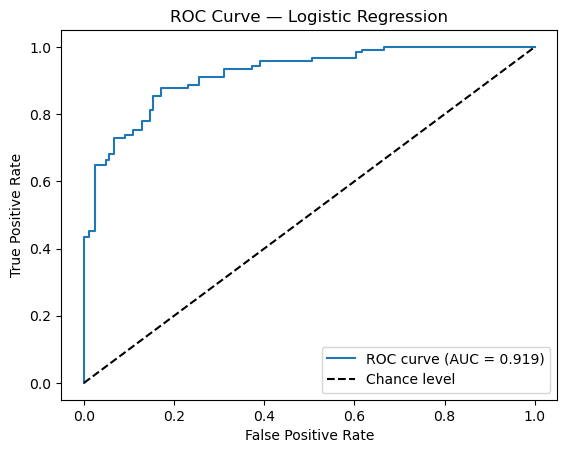

In [10]:
from sklearn.metrics import roc_curve, auc
y_prob_log = clf_log.predict_proba(X_test)[:, 1]

# 2. Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log, pos_label=1)

# 3. Compute the area under the curve
auc_log = auc(fpr, tpr)
print(f"\nLogistic Regression AUC: {auc_log:.3f}")

# 4. Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_log:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression')
plt.legend(loc='lower right')
plt.show()

An AUC of 0.919 indicates excellent discrimination—the model correctly ranks a randomly chosen Alzheimer patient above a non-Alzheimer patient 91.9% of the time. The ROC plot’s curve bows strongly toward the upper‐left, well above the 45° “chance” diagonal, demonstrating good trade‐off between true positive rate and false positive rate across thresholds.

#### The outputs from Problems 1 and 2 serve different goals:

Problem 1 (Logistic regression): Focuses on inference—estimating how each predictor relates to the odds of Alzheimer’s (coefficients, odds ratios, p-values, CIs). It tells us which variables matter and by how much, but not how well we’ll classify new patients.

Problem 2 (Confusion matrix): Evaluates predictive performance—how accurately the fitted model labels test‐set observations (accuracy, sensitivity, specificity, precision). It tells us how well the model predicts dementia status in practice, but not why predictors are significant.

In [11]:
# --- Part 5: Decision Tree ---
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
y_prob_tree = clf_tree.predict_proba(X_test)[:,1]

print("\nDecision Tree Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_tree))
print(metrics.classification_report(y_test, y_pred_tree))
auc_tree = metrics.roc_auc_score(y_test, y_prob_tree)
print(f"Decision Tree AUC: {auc_tree:.3f}")


Decision Tree Confusion Matrix:
[[164   0]
 [  9 113]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       164
           1       1.00      0.93      0.96       122

    accuracy                           0.97       286
   macro avg       0.97      0.96      0.97       286
weighted avg       0.97      0.97      0.97       286

Decision Tree AUC: 0.963


The tree perfectly avoids false positives (100% specificity) and catches 92.6% of Alzheimer cases. With only 9 false negatives, it markedly improves on the logistic model’s sensitivity while maintaining perfect precision. AUC = 0.963 further confirms strong overall discrimination.



In [12]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
y_prob_rf = clf_rf.predict_proba(X_test)[:,1]

print("\nRandom Forest Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_rf))
print(metrics.classification_report(y_test, y_pred_rf))
auc_rf = metrics.roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest AUC: {auc_rf:.3f}")


Random Forest Confusion Matrix:
[[164   0]
 [  6 116]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       164
           1       1.00      0.95      0.97       122

    accuracy                           0.98       286
   macro avg       0.98      0.98      0.98       286
weighted avg       0.98      0.98      0.98       286

Random Forest AUC: 0.997


Random Forest further reduces false negatives (only 6 missed Alzheimer cases), boosting sensitivity to 95.1% while still avoiding false positives. Its AUC of 0.997 indicates near‐perfect class separation.

In [13]:
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [
        metrics.accuracy_score(y_test, y_pred_log),
        metrics.accuracy_score(y_test, y_pred_tree),
        metrics.accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        metrics.precision_score(y_test, y_pred_log),
        metrics.precision_score(y_test, y_pred_tree),
        metrics.precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        metrics.recall_score(y_test, y_pred_log),
        metrics.recall_score(y_test, y_pred_tree),
        metrics.recall_score(y_test, y_pred_rf)
    ],
    'F1 Score': [
        metrics.f1_score(y_test, y_pred_log),
        metrics.f1_score(y_test, y_pred_tree),
        metrics.f1_score(y_test, y_pred_rf)
    ],
    'AUC': [auc_log, auc_tree, auc_rf]
})

# <-- Here is your replacement for display_dataframe_to_user:
print("\nModel Comparison:")
print(metrics_df)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.828671   0.841121  0.737705  0.786026  0.919232
1        Decision Tree  0.968531   1.000000  0.926230  0.961702  0.963115
2        Random Forest  0.979021   1.000000  0.950820  0.974790  0.997001


Based on accuracy, recall, F1-score, and especially AUC, the Random Forest is the top performer. It maximizes true positives without any false positives and achieves near‐perfect AUC, making it the best predictor of Alzheimer’s status among the three.

### Part 8: Journal Article Discussion
I reviewed Velazquez & Lee (2021), who applied a balanced Random Forest model to predict conversion from Early Mild Cognitive Impairment (EMCI) to Alzheimer’s Disease (AD) using clinical data (Velazquez & Lee, 2021) .

Domain problem: EMCI patients represent a prodromal stage before full‐blown AD, and accurately predicting which EMCI subjects will convert to AD is crucial for early intervention and trial recruitment (Velazquez & Lee, 2021) .

Method technique:

Random Forest is an ensemble of decision trees built on bootstrapped samples with random feature subsets at each split (Breiman, 2001).

It excels at handling high‐dimensional, multi‐modal clinical and imaging features, provides robust predictions, and natively yields feature‐importance scores for interpretability.

In Velazquez & Lee’s work, they balanced the initially imbalanced EMCI_C (converter) vs. EMCI_NC (non‐converter) classes via oversampling, trained 1 000 trees, and evaluated performance on a held‐out test set.

Domain findings:

Their balanced Random Forest achieved 93.6% accuracy and 96% AUC on 383 EMCI patients (49 converters, 334 non‐converters) (Velazquez & Lee, 2021).

Feature‐importance analysis highlighted which clinical biomarkers and cognitive scores most strongly influenced individual conversion predictions, offering actionable insights for clinicians.

References (APA):
Breiman, L. (2001). Random forests. Machine Learning, 45(1), 5–32.
Velazquez, M., & Lee, Y., for the Alzheimer’s Disease Neuroimaging Initiative. (2021). Random forest model for feature-based Alzheimer’s disease conversion prediction from early mild cognitive impairment subjects. PLoS ONE, 16(4), e0244773. https://doi.org/10.1371/journal.pone.0244773